In [1]:
!pip install estnltk==1.7.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.2/222.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.7 MB/s eta 0:00:00


In [2]:
!pip install tweetnlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while

In [38]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas()

from estnltk import Text

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [4]:
# connect to drive
from google.colab import drive
from google.colab import files

drive.mount("/content/drive")
data = pd.read_csv("/content/drive/MyDrive/EstonianStanceDetection/notebooks/data.csv")

data["morph_analysis"] = data["sentence"].apply(lambda s: Text(s).tag_layer())

for feature in ["named_entities", "noun_phrases", "adjectives", "quoted_words", "diminutives", "superlatives", "conditionals", "translatives", "indirects", "stopwords", "unique_stopwords"]:
  data[feature] = data[feature].apply(eval)

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# local
data = pd.read_csv("data.csv")

#EmoLex and EKI

In [5]:
# drive
emolex = pd.read_csv("/content/drive/MyDrive/EstonianStanceDetection/notebooks/Estonian-NRC-EmoLex.txt", delimiter="\t")

In [ ]:
# local
emolex = pd.read_csv("Estonian-NRC-EmoLex.txt", delimiter="\t")

In [6]:
emolex = emolex.rename(columns={"Estonian Word" : "word"})

In [7]:
# combine neg & pos emotions
emolex["negative_overall"] = emolex["negative"] + emolex["anger"] + emolex["disgust"] + emolex["fear"] + emolex["sadness"]
emolex["positive_overall"] = emolex["positive"] + emolex["anticipation"] + emolex["joy"] + emolex["surprise"] + emolex["trust"]

In [8]:
emolex = emolex.drop(columns=emolex.columns[:-3]) # 14154
emolex = emolex[(emolex["negative_overall"] != 0) | (emolex["positive_overall"] != 0)] # 6453
emolex = emolex.dropna() # 6452
emolex["lemma"] = emolex["word"].progress_apply(lambda w: Text(w).tag_layer().morph_analysis.lemma[0][0])
emolex = emolex[emolex["word"] == emolex["lemma"]] # 5176
emolex = emolex.drop(columns=["lemma"])
emolex = emolex.groupby('word').sum()
emolex.reset_index(inplace=True) # 4226
emolex = emolex[((emolex["negative_overall"] == 0) & (emolex["positive_overall"] > 0)) | ((emolex["negative_overall"] > 0) & (emolex["positive_overall"] == 0))] # 3693

100%|██████████| 6452/6452 [00:10<00:00, 599.57it/s]


In [9]:
emolex['sentiment'] = 0
emolex.loc[(emolex['positive_overall'] > 0), 'sentiment'] = 1
emolex.loc[(emolex['negative_overall'] > 0), 'sentiment'] = -1
emolex.drop(columns=['negative_overall', 'positive_overall'], inplace=True)

dict_emolex = emolex.set_index('word')['sentiment'].to_dict()

In [10]:
emolex["sentiment"].value_counts()

sentiment
-1    1908
 1    1785
Name: count, dtype: int64

In [11]:
url = "https://raw.githubusercontent.com/EKT1/valence/master/valence/sqnad.csv"

ekilex = pd.read_csv(url, header=None, on_bad_lines='skip', names=["word", "sentiment", "_"])
ekilex = ekilex.drop(columns=["_"])
ekilex["lemma"] = ekilex["word"].progress_apply(lambda w: Text(w).tag_layer().morph_analysis.lemma[0][0])
ekilex = ekilex[ekilex["word"] == ekilex["lemma"]]
ekilex = ekilex.drop(columns=["lemma"]) # 2454

dict_ekilex = ekilex.set_index('word')['sentiment'].to_dict()

100%|██████████| 39865/39865 [01:00<00:00, 656.02it/s]


In [12]:
ekilex["sentiment"].value_counts()

sentiment
-1    1458
 1     987
-8       9
Name: count, dtype: int64

In [13]:
def lexicon_sentiment(morph_layer, dict_lexicon):
  score = 0
  negation = False
  lemma_list = [l[0] for l in morph_layer.lemma if l[0].isalpha()]

  for lemma in lemma_list:
    if lemma in dict_lexicon.keys():
      sentiment = dict_lexicon[lemma]
      if negation:
         sentiment = -sentiment
         negation = False
      score += sentiment

  return score

In [14]:
def sentiment_map(score):
  return "pos" if score > 0 else "neg" if score < 0 else "neu"

data["ekilex_sentiment"] = data["morph_analysis"].progress_apply(lambda ma: lexicon_sentiment(ma, dict_ekilex))
data["ekilex_sentiment"] = data["ekilex_sentiment"].progress_apply(lambda score: sentiment_map(score))

data["emolex_sentiment"] = data["morph_analysis"].progress_apply(lambda ma: lexicon_sentiment(ma, dict_emolex))
data["emolex_sentiment"] = data["emolex_sentiment"].progress_apply(lambda score: sentiment_map(score))

100%|██████████| 3261/3261 [00:00<00:00, 426014.62it/s]


#Emotsioonidetektor

In [15]:
import requests

def ekiEmotionDetector(sentence):
    url = 'http://peeter.eki.ee:5000/valence/color'
    form_data = {'text': sentence}
    response = requests.post(url, data=form_data)

    if response.status_code != 200:
        return {"err" : response.status_code}

    content = response.text.split("\n")[120:140]
    emotions = ["pos", "neg", "neu"]
    scores = []

    for line in content:
        if "Tõenäosus" not in line:
            continue

        line = line[line.find("Tõenäosus"):].strip()

        for emotion in ["positiivne", "negatiivne", "neutraalne"]:
            i = line.find(emotion) + len(emotion) + 3
            score = float(line[i:i+4])
            scores += [score]
        break

    return emotions[scores.index(max(scores))]
    # return dict(zip(emotions, scores))

In [16]:
data["eki_emotion"] = data["sentence"].progress_apply(lambda s: ekiEmotionDetector(s))

100%|██████████| 3261/3261 [16:25<00:00,  3.31it/s]


#EstBERT sentiment

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("tartuNLP/EstBERT128_sentiment")
model = AutoModelForSequenceClassification.from_pretrained("tartuNLP/EstBERT128_sentiment", max_length=256)

nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [18]:
data["estbert_sentiment"] = data["sentence"].progress_apply(lambda s: nlp(s)[0]["label"][:3])

100%|██████████| 3261/3261 [12:31<00:00,  4.34it/s]


# XLM-RoBERTa

In [19]:
import tweetnlp
model = tweetnlp.Classifier("cardiffnlp/xlm-roberta-base-sentiment-multilingual", max_length=256)

In [20]:
data["xlmroberta_sentiment"] = data["sentence"].progress_apply(lambda s: model.predict(s)["label"][:3])

100%|██████████| 3261/3261 [14:35<00:00,  3.72it/s]


#Analysis

In [31]:
stance_map = {
    "against" : "neg",
    "neutral" : "neu",
    "supportive" : "pos"
}

data["stance_map"] = data["stance"].map(stance_map)

In [32]:
data[["stance", "emolex_sentiment", "ekilex_sentiment", "eki_emotion", "estbert_sentiment", "xlmroberta_sentiment", "sentence"]]

,stance,emolex_sentiment,ekilex_sentiment,eki_emotion,estbert_sentiment,xlmroberta_sentiment,sentence
0,against,pos,neu,pos,neg,neg,"Ja selliseid inimesi on Eesti võimukoridorides ohtralt! Veel hullem on kogu see maailma päästmine, kus meile on Brüsseli käsul oma huvidest tähtsamad Süüria sõjapõgenikud, üle Vahemere tulevad neegritest majandusimmigrandid, Lääne-Euroopas välja mõeldud geiõigused ja sooneutraalsus, mujalt siia tulevad töölised ja nii edasi – ainult mitte omad inimesed."
1,against,neg,pos,neg,neg,neg,Massiimmigratsioon oleks Euroopale hukatuslik ja see ei lahendaks maailmas mitte midagi.
2,against,neu,neg,neg,neg,neg,"Lõppjäreldus on, et Eesti rahvaarv kasvab võõraste sisserändest, mis on rahvusriigile ohtlik.“Iga-aastase paarituhandelise sisserände ülekaalu puhul hakkaks eestlaste suhtarv rahvastikus aegamööda vähenema.”"
3,neutral,neu,neu,pos,neg,neg,"Kui meeleavaldajad hakkavad liikuma, organiseerijate palvel kõhedusttekitavalt vaikides, ühineb pensionär nendega.ee juhtus demonstratsioonil, mille korraldas PEGIDA ehk Patriotische Europäer gegen die Islamisierung des Abendlandes (patriootlikud eurooplased õhtumaa islamiseerimise vastu)"
4,neutral,neg,neg,neg,neu,neg,"See sõda tähendab, et peame ka Eestis oma julgeolekus arvesse võtma islami ekstremismi ohu hoopis uut olukorda silmas pidades."
...,...,...,...,...,...,...,...
3256,against,neg,pos,neg,neg,neg,"Kreeka suuruselt teise linna Thessaloniki lähistel asuvas endises Softexi tualettpaberitehases asuvas valitsuse peetavas põgenikelaagris ei julge naised öösiti ka enam omapäi tualetti minna, kuna see ei ole lihtsalt turvaline, kirjeldas kohapeal viibinud abiorganisatsiooni Médecins Sans Frontičres eestkõneleja Anna Chiara Nava."
3257,supportive,pos,pos,pos,pos,pos,"Hanso sõnul tuleb igale pagulasele, kes valib oma sihtriigiks Eesti, tagada kiire keeleõpe, aidata leida sobiv töökoht ning võimaldada elada turvaliselt Eestis niikaua, kuni tal on võimalik koju tagasi pöörduda."
3258,against,neg,neg,neg,neg,neg,Ja mõnes kohas peavad nad pärast saabumist elama laagrites nagu pagulased teise maailmasõja ajal.
3259,neutral,pos,pos,pos,neg,neg,"Nädalaid on peetud pika laua istumisi, aga kas keegi on kuulnud mingitki lahendust kuidas tagada Eesti inimestele töö eest väärikas palk, kuis peatada väljaränne ja tagada maakoolide kestmine või mida teha selleks, et kõik siin sündinud ja Eestit oma koduks pidavad inimesed end vajaliku ja omana tunneks?"


In [33]:
sentiments = ["emolex_sentiment", "ekilex_sentiment", "eki_emotion", "estbert_sentiment", "xlmroberta_sentiment"]

stance_classes = ["supportive", "neutral", "against"]
sentiment_classes = ["pos", "neu", "neg"]

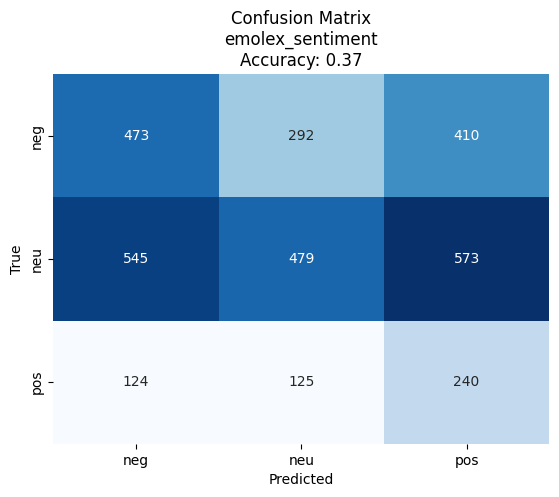

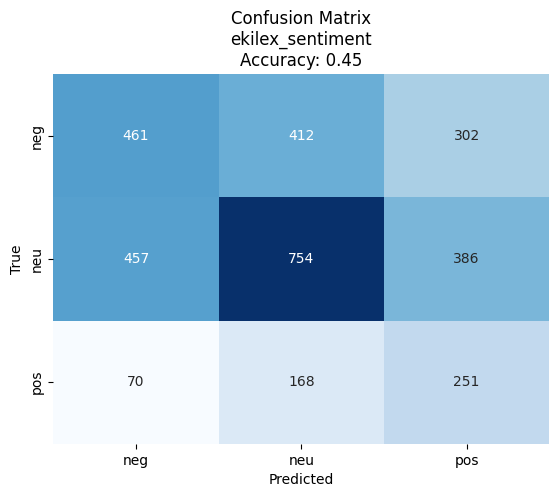

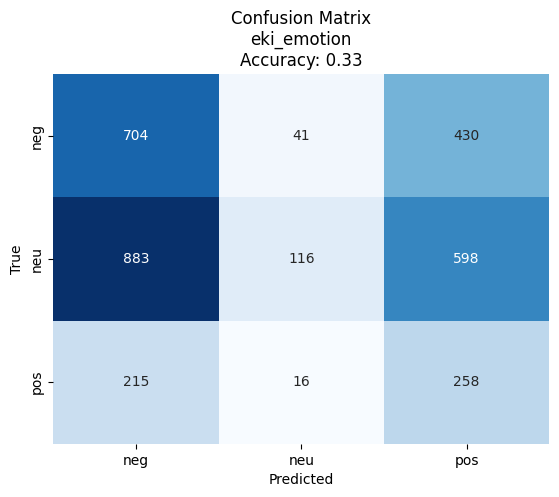

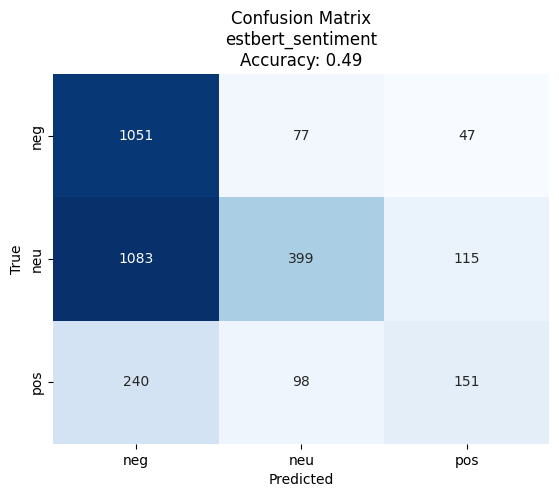

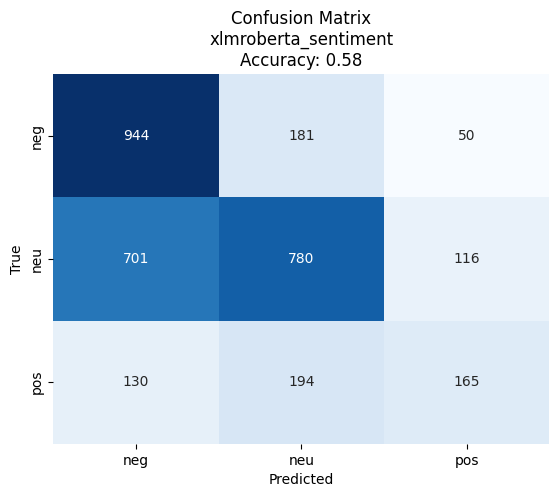

In [34]:
for f in sentiments:

  cm = confusion_matrix(data["stance_map"], data[f])
  accuracy = accuracy_score(data["stance_map"], data[f])

  plt.figure()
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['neg', 'neu', 'pos'], yticklabels=['neg', 'neu', 'pos'])
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(f"Confusion Matrix\n{f}\nAccuracy: {accuracy:.2f}")
  plt.show()
  print()

In [35]:
for f in sentiments:
  cr = classification_report(data["stance_map"], data[f])
  print(f)
  print(cr)

emolex_sentiment
              precision    recall  f1-score   support

         neg       0.41      0.40      0.41      1175
         neu       0.53      0.30      0.38      1597
         pos       0.20      0.49      0.28       489

    accuracy                           0.37      3261
   macro avg       0.38      0.40      0.36      3261
weighted avg       0.44      0.37      0.38      3261

ekilex_sentiment
              precision    recall  f1-score   support

         neg       0.47      0.39      0.43      1175
         neu       0.57      0.47      0.51      1597
         pos       0.27      0.51      0.35       489

    accuracy                           0.45      3261
   macro avg       0.43      0.46      0.43      3261
weighted avg       0.49      0.45      0.46      3261

eki_emotion
              precision    recall  f1-score   support

         neg       0.39      0.60      0.47      1175
         neu       0.67      0.07      0.13      1597
         pos       0.20      

In [36]:
def plot_with_ci(ax, dataframe, category, color):
    freq = relative_freq_df[category]
    p = freq / 100
    n = dataframe.sum(axis=1)
    se = np.sqrt(p * (1 - p) / n)
    ci = se * norm.ppf(0.995)
    ci_lower = (p - ci) * 100
    ci_upper = (p + ci) * 100
    error = [freq - ci_lower, ci_upper - freq]

    ax.bar(freq.index, freq, width=0.7, color=color, label=category)
    ax.errorbar(freq.index, freq, yerr=error, fmt='o', color='black', capsize=5)
    ax.set_xlabel('Stance')
    ax.set_ylabel('Relative Frequency (%)')
    ax.margins(y=0.1)

    for i, value in enumerate(freq):
        ax.text(x=i, y=ci_upper[i], s=f'{dataframe.at[freq.index[i], category]}', ha='center', va='bottom')

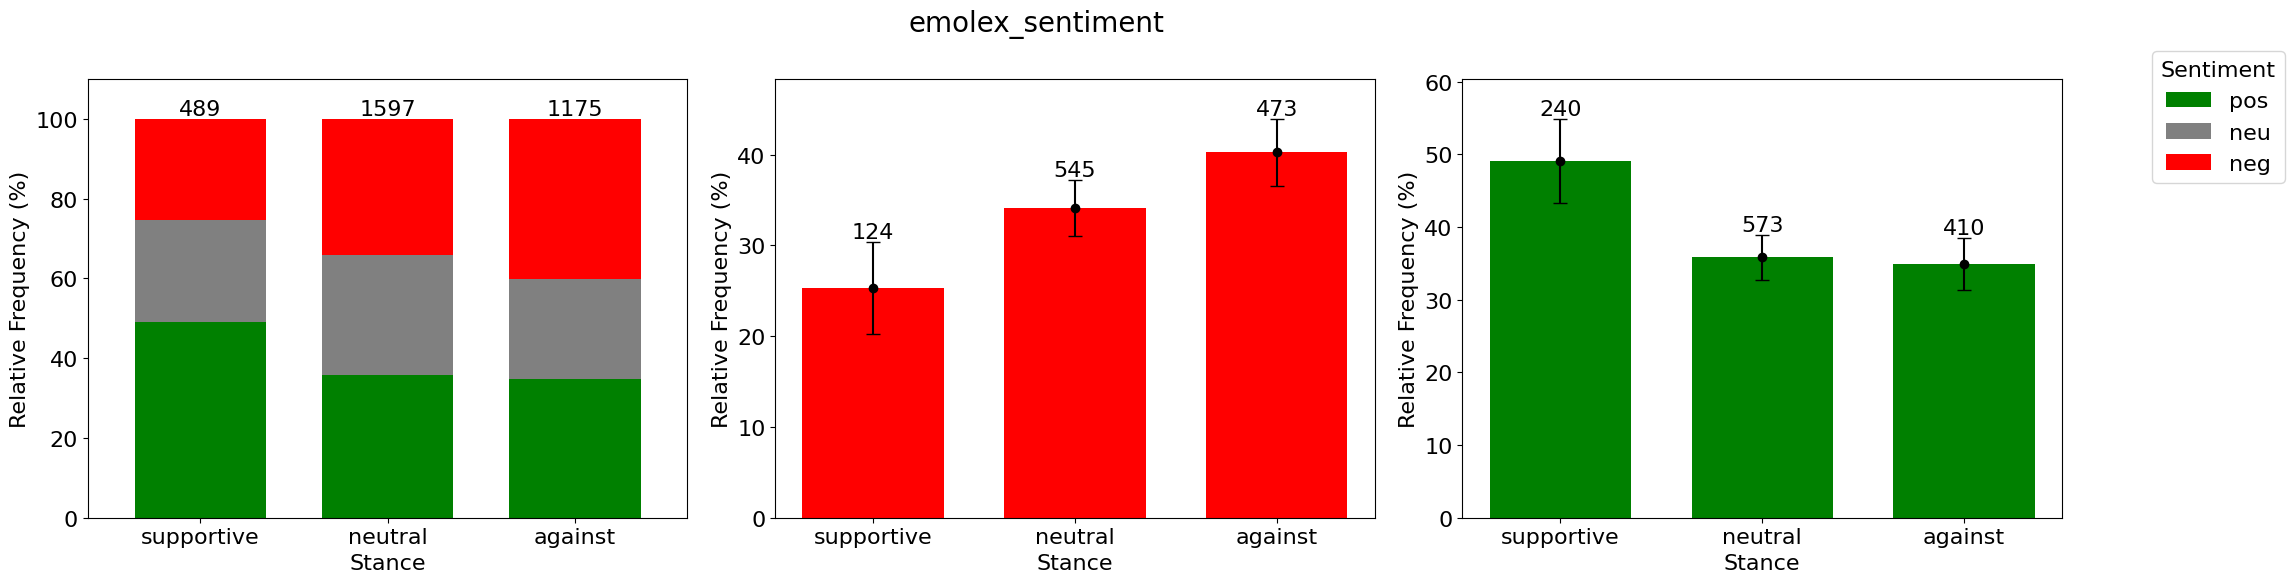

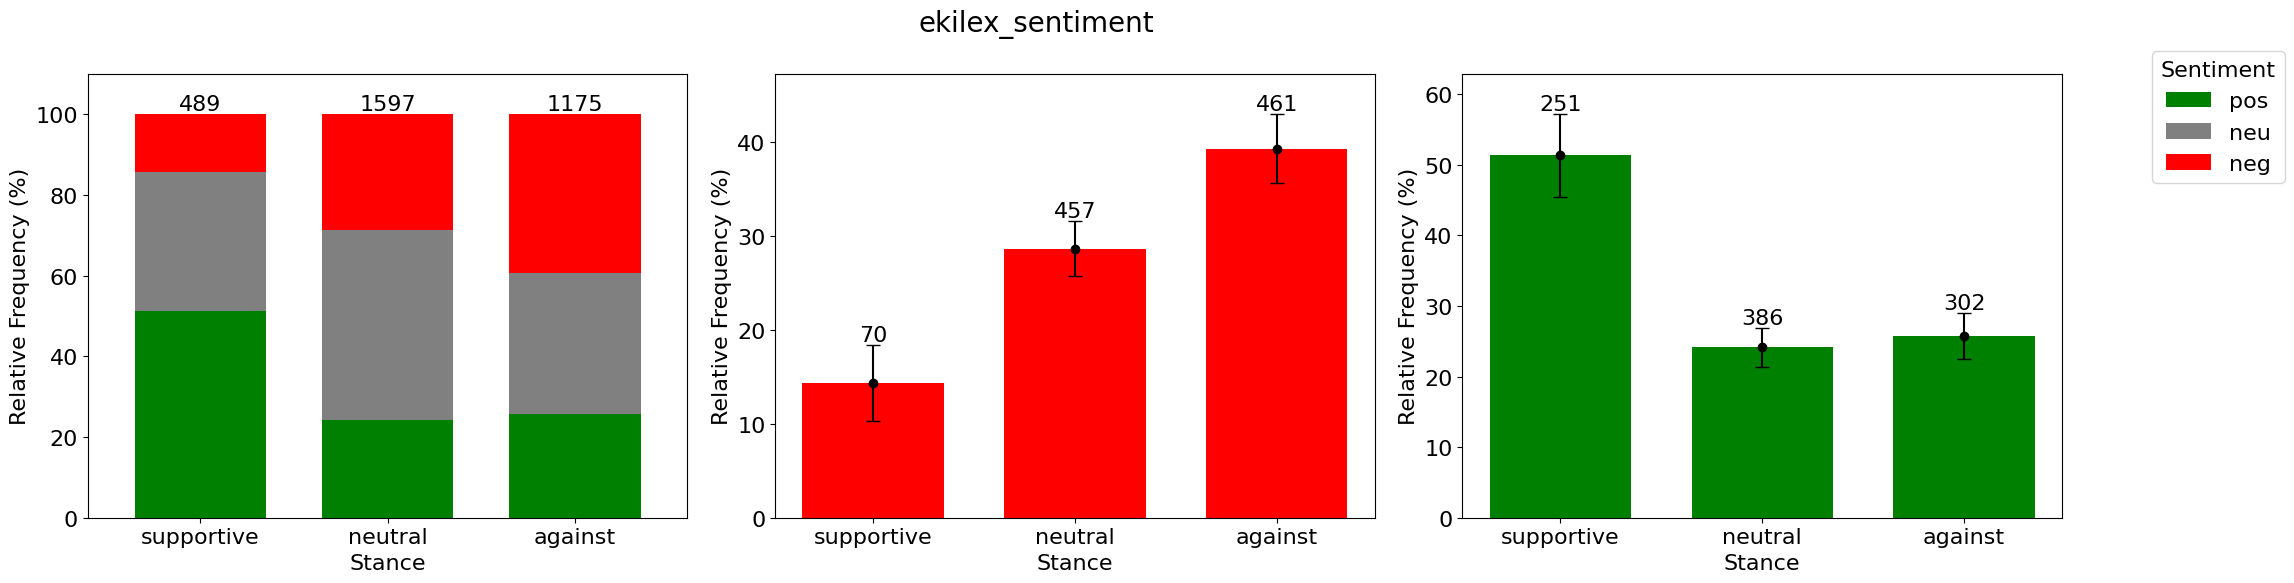

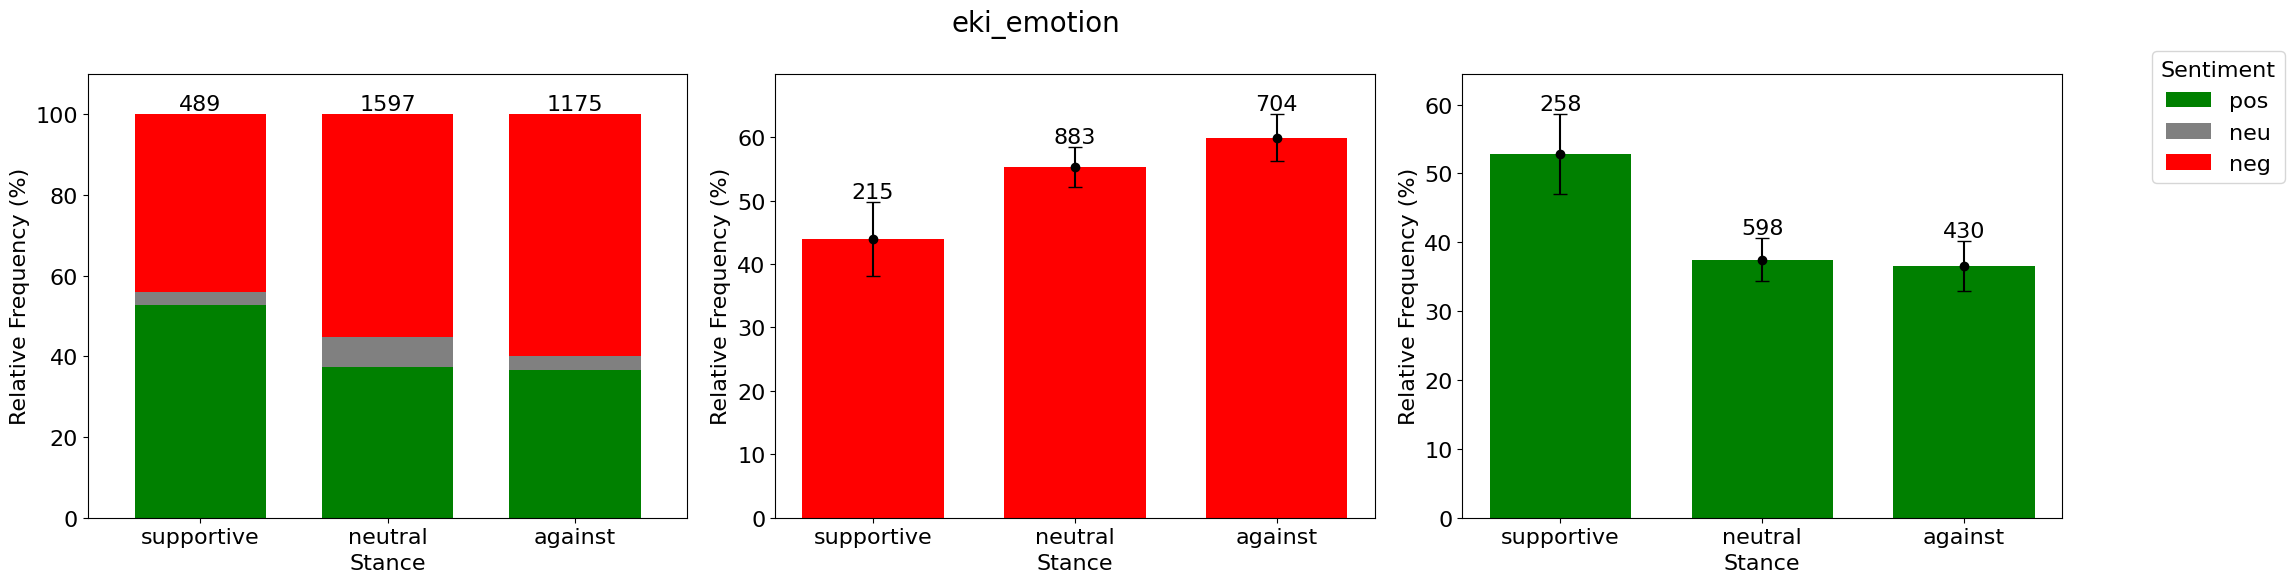

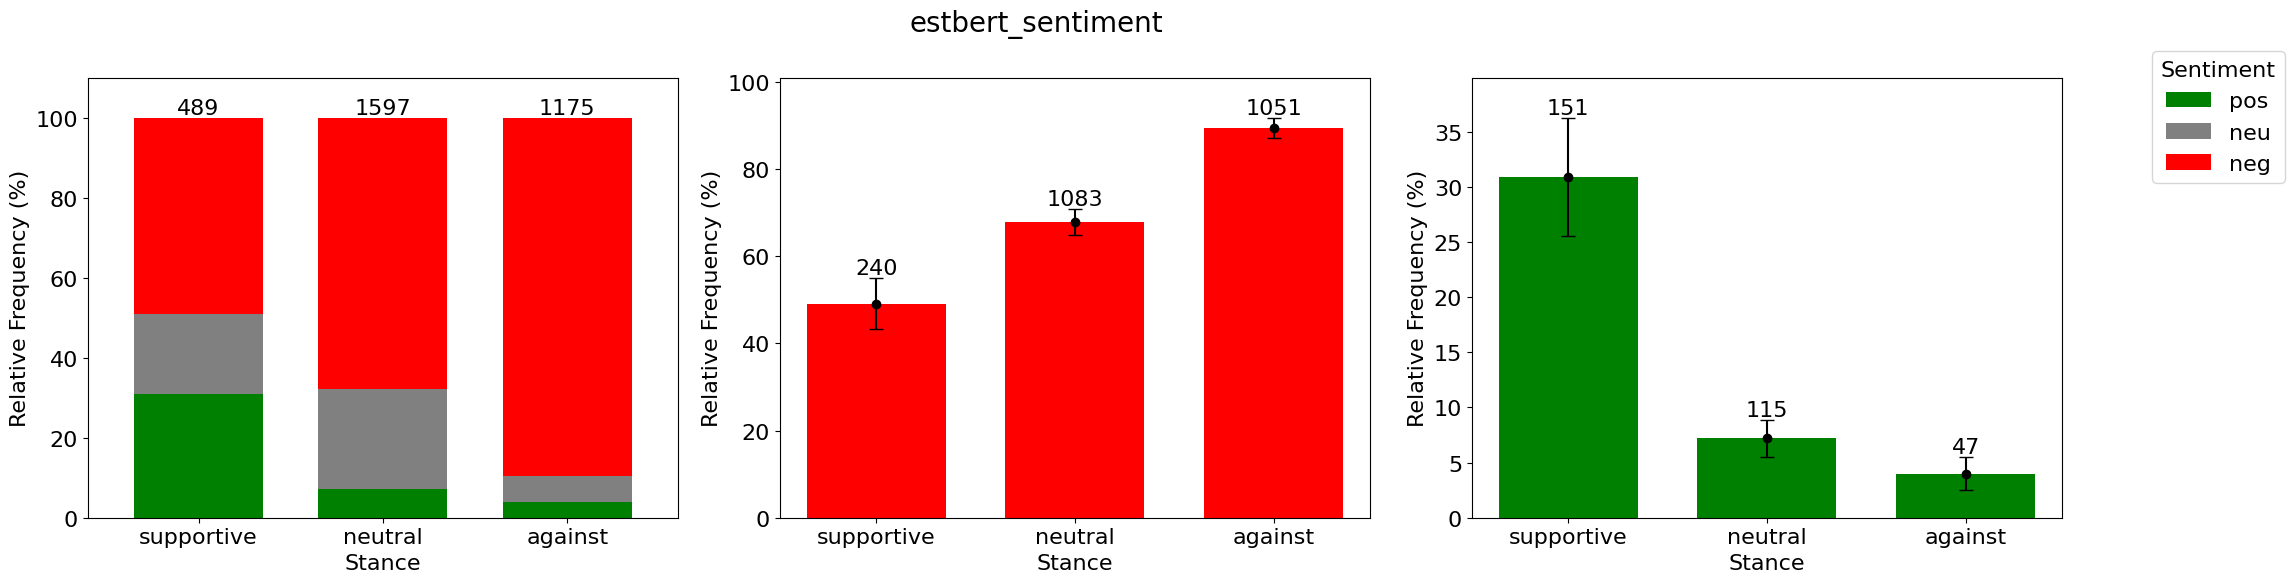

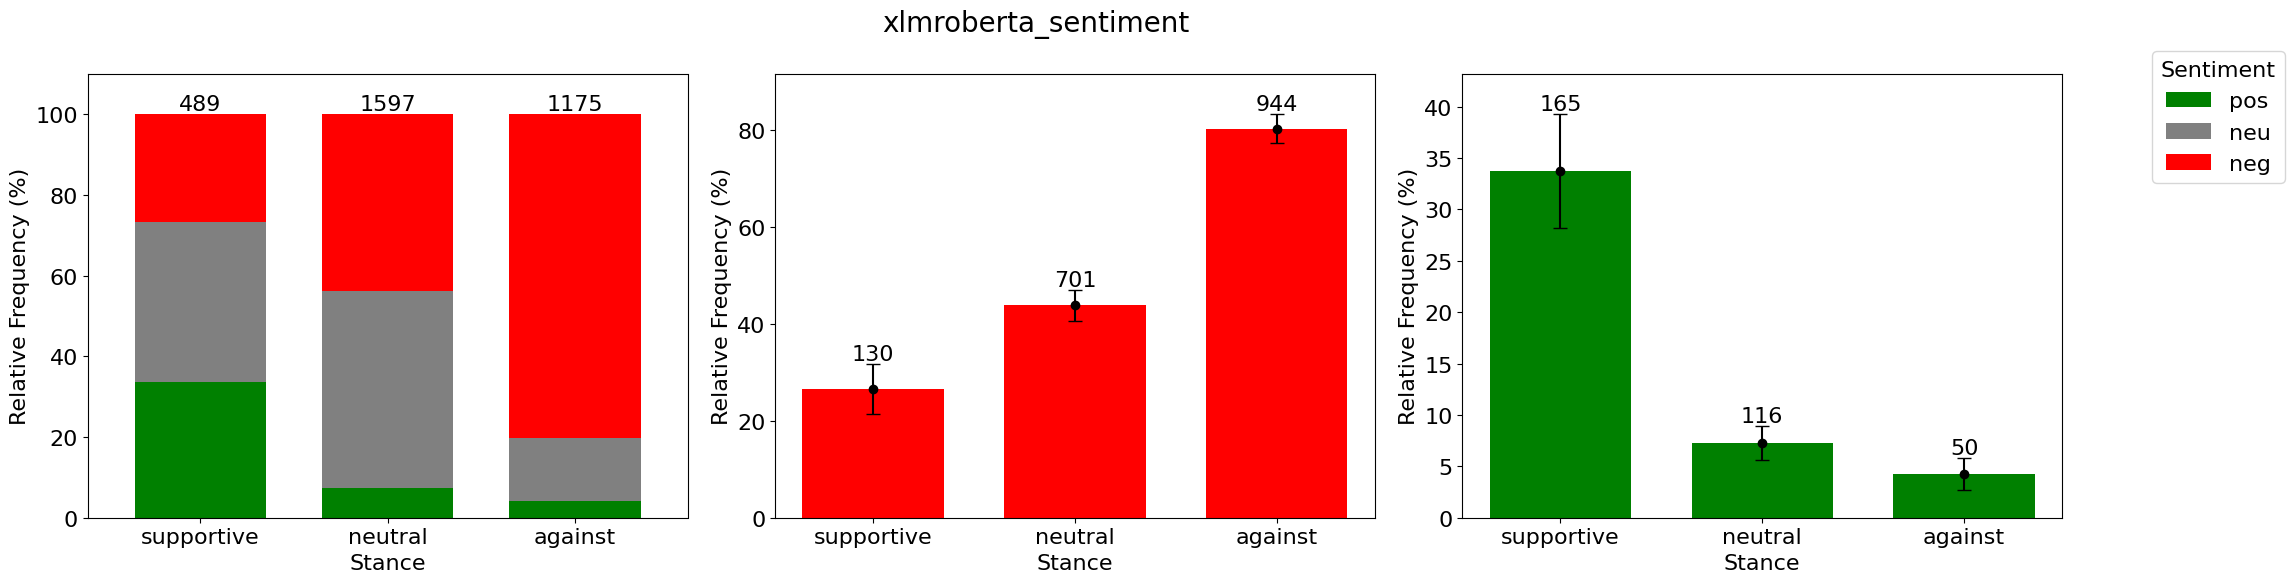

In [39]:
for sentiment in sentiments:
  sentiment_df = pd.crosstab(data["stance"], data[sentiment])
  sentiment_df = sentiment_df.reindex(index=stance_classes, columns=sentiment_classes)

  relative_freq_df = sentiment_df.div(sentiment_df.sum(axis=1), axis=0) * 100

  colors = {'pos': 'green', 'neu': 'gray', 'neg': 'red'}

  plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'legend.fontsize': 16})

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

  plt.suptitle(sentiment, fontsize=20)

  relative_freq_df.plot(kind='bar', width=0.7, stacked=True, ax=axes[0], color=[colors[col] for col in relative_freq_df.columns])
  axes[0].set_xlabel('Stance')
  axes[0].set_ylabel('Relative Frequency (%)')
  axes[0].tick_params(axis='x', rotation=0)
  axes[0].get_legend().remove()
  axes[0].margins(y=0.1)

  for i, (index_value, row) in enumerate(relative_freq_df.iterrows()):
      y_offset = row.sum()
      axes[0].text(x=i, y=y_offset, s=f'{sentiment_df.loc[index_value].sum()}', ha='center', va='bottom')

  plot_with_ci(axes[1], sentiment_df, 'neg', 'red')

  plot_with_ci(axes[2], sentiment_df, 'pos', 'green')

  fig.legend(sentiment_classes, title='Sentiment', bbox_to_anchor=(1.1, 0.8), loc='center right')

  plt.tight_layout()
  plt.show()
  print()

---

In [40]:
data = data.drop(columns=['stance_map'])

In [41]:
# download file (google drive)
from google.colab import drive
from google.colab import files

drive.mount("/content/drive")
data.to_csv("/content/drive/MyDrive/EstonianStanceDetection/notebooks/data.csv", index=False)
# files.download("data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# local
data.to_csv("data.csv", index=False)